In [2]:
import os
import math
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten
from sklearn.model_selection import train_test_split

In [12]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os

# # Define the path to the local directory where the files are stored
# local_path = './computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/'

# # Walk through the directory and subdirectories
# for dirname, _, filenames in os.walk(local_path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def read_image(path,ismask = 0):
    path = path.decode()
    if(ismask == 1):
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        ret,img = cv2.threshold(img,70,255,0)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img/255.0
        img = np.expand_dims(img,axis = -1)
        img = img.astype(np.float32)
    else:
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img / 255.0
        img = img.astype(np.float32)
    return img

In [3]:
smooth = 1e-6
def dice_coeff(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - tf.compat.v1.reduce_mean(dice_coeff(y_true, y_pred))

In [14]:
# !pip install --upgrade keras

In [13]:
# !pip install tensorflow

In [9]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true) + K.sum(y_pred) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [16]:
import tensorflow as tf
model = tf.keras.models.load_model(r"./model-files/resnet-weights (1).hdf5")

In [17]:
from keras.utils import custom_object_scope

with custom_object_scope({'dice_loss': dice_loss, 'dice_coeff': dice_coeff, 'jacard_coeff': jacard_coeff}):
    # Load your model
    model_seg = tf.keras.models.load_model('./model-files/Brain_tumour_model_mask (2).h5')

In [18]:
def prediction(img_path):
    img = img_path *1./255.
    #reshaping
    img = cv2.resize(img, (256,256))
    # converting img into array
    img = np.array(img, dtype=np.float64)
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction for tumor in image
    is_defect = model.predict(img)
    if np.argmax(is_defect) == 0:
        status = False
    else:
        status = True

    return status

In [20]:
import cv2

In [28]:
img_path = cv2.imread(r'./computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27.jpg')


In [29]:
img = cv2.resize(img_path, (128, 128))

In [31]:
mask_path = cv2.imread('./computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/049/brain/27_HGE_Seg.jpg')

In [36]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 69ms/step
yes
1/1 [==============================] - 0s 88ms/step


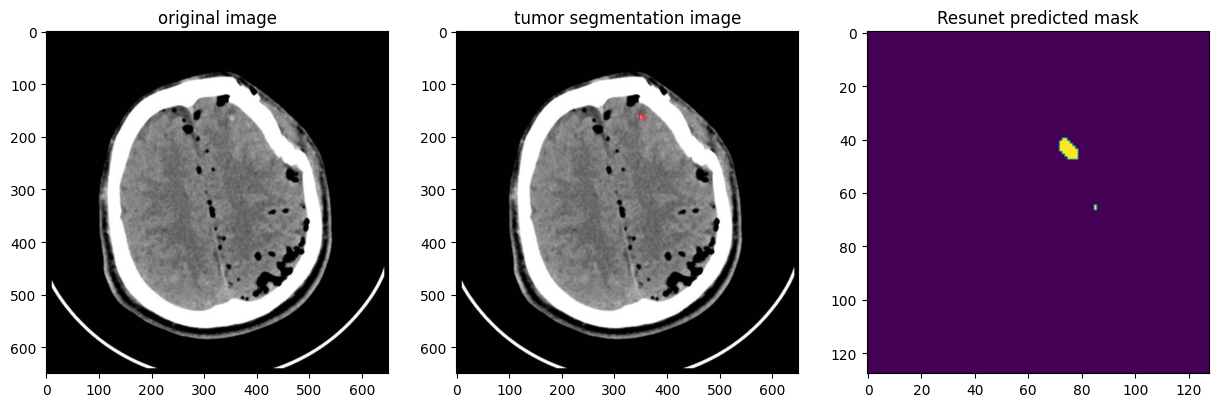

In [37]:
# if tumour is not present we append the details of the image to the list
if prediction(img_path) ==True:
    print('yes')
    X = np.empty((1, 128, 128, 3))
    # read the image
    # resizing the image and coverting them to array of type float64
    img = cv2.resize(img_path, (128, 128))
    img = np.array(img, dtype=np.float64)

    # standardising the image
    img -= img.mean()
    img /= img.std()
    # converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    # make prediction of mask
    predict = model_seg.predict(X)
    # if sum of predicted mask is 0 then there is not tumour
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
#     original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
    axs[0].imshow(original_img)
    axs[0].title.set_text('original image')
    
    #read predicted mask
    pred = np.array(predict.squeeze().round())
    axs[2].imshow(pred)
    axs[2].title.set_text('Resunet predicted mask')

    # read original mask
#     mask_img = cv2.imread(mask_path)
    mask_img = cv2.cvtColor(mask_path, cv2.COLOR_BGR2GRAY)

    # overlay original mask with MRI
    original_img[mask_img == 255] = (255, 0, 0)
    axs[1].imshow(original_img)
    axs[1].title.set_text('tumor segmentation image')

    plt.show()

else:
    print('no tumor ')
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    axs[0].imshow(original_img)
    axs[0].title.set_text('original image')